# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.2

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.1 + 1.3 * (year/45), 0.75)
    else:
        p = min(0.1 + 1.9 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.4

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai_risk.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2023:
        return 0.03
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.01
    elif year == 2024 or year == 2025:
        return 0.047   # makes cumulative probability by EOY 2025 = 0.1
                        # solve 0.01 + (1-0.01)*X + (1-0.01)(1-X)*X = 0.1, 0>X<1
    elif year < 2030:
        return 0.078 # makes cumulative probability by EOY 2029 = 0.4
                     # solve 0.1 + (1-0.1)*X + (1-0.1)(1-X)*X + (1-0.1)(1-X)^2*X + (1-0.1)(1-X)^3*X + (1-0.1)(1-X)^4*X = 0.4
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.6
                     # 0.4 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.6
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
tai_years = bayes.bayesnet(load_cache_file='caches/tai_years')
tai_years = [y['tai_year'] for y in tai_years]

# TODO: War spending
# TODO: TAI China delay
# TODO: TAI Catastrophe delay

sq.get_percentiles(tai_years)


{1: 2025.0,
 5: 2028.0,
 10: 2030.0,
 20: 2036.0,
 30: 2042.0,
 40: 2048.0,
 50: 2056.0,
 60: 2066.0,
 70: 2082.0,
 80: 2124.0,
 90: 2124.0,
 95: 2124.0,
 99: 2124.0}

### Overall module structure

In [11]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


In [12]:
for i in range(20):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

############
## RUN 1 ##
############
--- /!\ TAI CREATED in 2031
2032: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
...Total loop complete in 41.17ms
-
-
############
## RUN 2 ##
############
2024: WAR!!! (US vs. China)
2029: War ends :)
2038: WAR!!! (US vs. China)
2058: War ends :)
...Total loop complete in 49.73ms
...Boring future
-
-
############
## RUN 3 ##
############
2032: WAR!!! (US vs. China)
2058: War ends :)
--- /!\ TAI CREATED in 2078
2079: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
...Total loop complete in 86.44ms
-
-
############
## RUN 4 ##
############
2030: WAR!!! (US vs. China)
2030: ...catastrophe from nukes (war)
2034: War ends :)
2035: North Korea uses a nuke first strike!
...Total loop complete in 42.2ms
...Boring future
-
-
############
## RUN 5 ##
############
2026: WAR!!! (US vs. China)
2026: ...catastrophe from nukes (war)
2048: War ends :)
...Total loop complete in 42.95ms
...Boring future
-
-

In [13]:
%%time
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            load_cache_file='caches/future_assessment_model_cache',
                            dump_cache_file='caches/future_assessment_model_cache',
                            reload_cache=False,
                            raw=True,
                            verbose=True,
                            cores=5,
                            n=RUNS)

Loading from cache file (`caches/future_assessment_model_cache.sqcache`)...
...Loaded
Caching in-memory...
...Cached!
Writing cache to file `caches/future_assessment_model_cache.sqcache`...
...Cached!
...Finding
...Found!
...All done!
CPU times: user 1min 30s, sys: 1min 45s, total: 3min 15s
Wall time: 3min 55s


In [14]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 92.61),
 ('aligned_tai', 2.315),
 ('xrisk_full_unaligned_tai_singleton', 1.97),
 ('xrisk_full_unaligned_tai_extinction', 1.405),
 ('xrisk_subtly_unaligned_tai', 0.925),
 ('xrisk_tai_misuse', 0.61),
 ('xrisk_nukes_war', 0.11),
 ('xrisk_nukes_accident', 0.03),
 ('xrisk_unknown_unknown', 0.015),
 ('xrisk_bio_nonstate', 0.01),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 63.93),
 ('aligned_tai', 19.72),
 ('xrisk_full_unaligned_tai_singleton', 5.46),
 ('xrisk_subtly_unaligned_tai', 4.605),
 ('xrisk_full_unaligned_tai_extinction', 3.935),
 ('xrisk_tai_misuse', 1.97),
 ('xrisk_nukes_war', 0.21),
 ('xrisk_nukes_accident', 0.105),
 ('xrisk_unknown_unknown', 0.045),
 ('xrisk_bio_nonstate', 0.015),
 ('xrisk_bio_accident', 0.005),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 45.34),
 ('aligned_tai',

In [15]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0B. Catastrophe States At Year
## 2023 ##
[('', 99.84)]
-
-
## 2030 ##
[('', 93.44),
 ('xrisk_full_unaligned_tai_singleton', 1.62),
 ('xrisk_full_unaligned_tai_extinction', 1.4),
 ('nukes_war', 1.33),
 ('engineered_pathogen', 0.57),
 ('xrisk_tai_misuse', 0.46),
 ('nukes_accident', 0.36),
 ('natural_pathogen', 0.36),
 ('averting_misaligned_tai', 0.27)]
-
-
## 2050 ##
[('', 82.59),
 ('xrisk_full_unaligned_tai_singleton', 4.21),
 ('xrisk_full_unaligned_tai_extinction', 3.79),
 ('nukes_war', 2.73),
 ('xrisk_tai_misuse', 1.47),
 ('engineered_pathogen', 1.46),
 ('nukes_accident', 1.1),
 ('natural_pathogen', 0.95),
 ('averting_misaligned_tai', 0.66),
 ('averting_intentional_tai', 0.13),
 ('nukes_war xrisk_full_unaligned_tai_singleton', 0.11)]
-
-
## 2070 ##
[('', 78.57),
 ('xrisk_full_unaligned_tai_singleton', 5.04),
 ('xrisk_full_unaligned_tai_extinction', 4.61),
 ('nukes_war', 3.04),
 ('engineered_pathogen', 2.02),
 ('xrisk_tai_misuse', 1.7),
 ('nukes_accident', 1.34),
 ('natural_pathogen',

In [16]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

0C. *First* Catastrophe State At Year
## 2023 ##
[('', 99.84)]
-
-
## 2030 ##
[('', 93.44),
 ('xrisk_full_unaligned_tai_singleton', 1.62),
 ('xrisk_full_unaligned_tai_extinction', 1.4),
 ('nukes_war', 1.39),
 ('engineered_pathogen', 0.61),
 ('xrisk_tai_misuse', 0.46),
 ('nukes_accident', 0.39),
 ('natural_pathogen', 0.38),
 ('averting_misaligned_tai', 0.29)]
-
-
## 2050 ##
[('', 82.59),
 ('xrisk_full_unaligned_tai_singleton', 4.21),
 ('xrisk_full_unaligned_tai_extinction', 3.79),
 ('nukes_war', 3.16),
 ('engineered_pathogen', 1.6),
 ('xrisk_tai_misuse', 1.47),
 ('nukes_accident', 1.24),
 ('natural_pathogen', 1.05),
 ('averting_misaligned_tai', 0.7),
 ('averting_intentional_tai', 0.14)]
-
-
## 2070 ##
[('', 78.57),
 ('xrisk_full_unaligned_tai_singleton', 5.04),
 ('xrisk_full_unaligned_tai_extinction', 4.61),
 ('nukes_war', 3.69),
 ('engineered_pathogen', 2.27),
 ('xrisk_tai_misuse', 1.7),
 ('nukes_accident', 1.57),
 ('natural_pathogen', 1.49),
 ('averting_misaligned_tai', 0.83),
 ('aver

In [17]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

0D. Double Catastrophe X-Risks
## 2030 ##
[('', 99.995), ('averting_misaligned_tai->nukes_accident', 0.005)]
-
-
## 2050 ##
[('', 99.985),
 ('averting_misaligned_tai->nukes_accident', 0.005),
 ('nukes_war->nukes_war', 0.005),
 ('nukes_accident->nukes_war', 0.005)]
-
-
## 2070 ##
[('', 99.97),
 ('nukes_accident->nukes_accident', 0.005),
 ('averting_misaligned_tai->nukes_accident', 0.005),
 ('nukes_war->nukes_war', 0.005),
 ('engineered_pathogen->nukes_war', 0.005),
 ('engineered_pathogen->nukes_accident', 0.005),
 ('nukes_accident->nukes_war', 0.005)]
-
-
## 2100 ##
[('', 99.955),
 ('engineered_pathogen->nukes_war', 0.01),
 ('nukes_accident->nukes_war', 0.01),
 ('nukes_war->nukes_war', 0.01),
 ('nukes_accident->nukes_accident', 0.005),
 ('averting_misaligned_tai->nukes_accident', 0.005),
 ('engineered_pathogen->nukes_accident', 0.005)]
-
-


In [18]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

0E. # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [19]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

0F. War States At Year
## 2030 ##
[('', 59.03),
 ('US/China', 34.1),
 ('US/Russia', 5.645),
 ('US/China US/China', 0.575),
 ('Other', 0.435),
 ('US/China US/Russia', 0.205),
 ('Other US/China', 0.01)]
-
-
## 2050 ##
[('', 43.275),
 ('US/China', 42.755),
 ('US/Russia', 8.085),
 ('US/China US/China', 2.48),
 ('Other', 2.275),
 ('US/China US/Russia', 0.67),
 ('Other US/China', 0.3),
 ('Other US/Russia', 0.07),
 ('US/Russia US/Russia', 0.04),
 ('US/China US/China US/China', 0.02),
 ('Other US/China US/China', 0.015),
 ('US/China US/Russia US/Russia', 0.005),
 ('Other Other', 0.005),
 ('US/China US/China US/China US/China', 0.005)]
-
-
## 2070 ##
[('US/China', 41.475),
 ('', 39.7),
 ('US/Russia', 9.28),
 ('Other', 4.17),
 ('US/China US/China', 2.52),
 ('US/China US/Russia', 1.155),
 ('Other US/China', 1.04),
 ('Other US/Russia', 0.25),
 ('US/Russia US/Russia', 0.165),
 ('US/China US/China US/China', 0.055),
 ('Other US/China US/China', 0.055),
 ('US/China US/China US/Russia', 0.04),
 ('Othe

In [20]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

0G. War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 28.6,
 80: 57.1,
 90: 85.7,
 95: 85.7,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 11.1,
 60: 22.2,
 70: 37.0,
 80: 51.9,
 90: 74.1,
 95: 88.9,
 99: 96.3}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 2.1,
 50: 8.5,
 60: 14.9,
 70: 23.4,
 80: 34.0,
 90: 55.3,
 95: 76.6,
 99: 95.7}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 2.6,
 50: 6.5,
 60: 10.4,
 70: 15.6,
 80: 23.4,
 90: 37.7,
 95: 51.9,
 99: 89.6}
-
-


In [21]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

0H. # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-


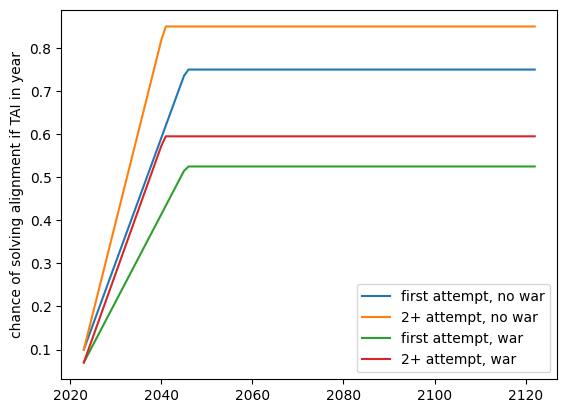

In [22]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [23]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2023 - chance of solving TAI alignment with no war 10.0% (2nd attempt 10.0%)
Year: 2024 - chance of solving TAI alignment with no war 13.0% (2nd attempt 14.0%)
Year: 2025 - chance of solving TAI alignment with no war 16.0% (2nd attempt 18.0%)
Year: 2026 - chance of solving TAI alignment with no war 19.0% (2nd attempt 23.0%)
Year: 2027 - chance of solving TAI alignment with no war 22.0% (2nd attempt 27.0%)
Year: 2028 - chance of solving TAI alignment with no war 24.0% (2nd attempt 31.0%)
Year: 2029 - chance of solving TAI alignment with no war 27.0% (2nd attempt 35.0%)
Year: 2030 - chance of solving TAI alignment with no war 30.0% (2nd attempt 40.0%)
Year: 2031 - chance of solving TAI alignment with no war 33.0% (2nd attempt 44.0%)
Year: 2032 - chance of solving TAI alignment with no war 36.0% (2nd attempt 48.0%)
Year: 2033 - chance of solving TAI alignment with no war 39.0% (2nd attempt 52.0%)
Year: 2034 - chance of solving TAI alignment with no war 42.0% (2nd attempt 56.0%)
Year

In [24]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


Year: 2023 - chance of solving TAI alignment with war 7.0% (2nd attempt 7.0%)
Year: 2024 - chance of solving TAI alignment with war 9.0% (2nd attempt 10.0%)
Year: 2025 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2026 - chance of solving TAI alignment with war 13.0% (2nd attempt 16.0%)
Year: 2027 - chance of solving TAI alignment with war 15.0% (2nd attempt 19.0%)
Year: 2028 - chance of solving TAI alignment with war 17.0% (2nd attempt 22.0%)
Year: 2029 - chance of solving TAI alignment with war 19.0% (2nd attempt 25.0%)
Year: 2030 - chance of solving TAI alignment with war 21.0% (2nd attempt 28.0%)
Year: 2031 - chance of solving TAI alignment with war 23.0% (2nd attempt 31.0%)
Year: 2032 - chance of solving TAI alignment with war 25.0% (2nd attempt 34.0%)
Year: 2033 - chance of solving TAI alignment with war 27.0% (2nd attempt 37.0%)
Year: 2034 - chance of solving TAI alignment with war 29.0% (2nd attempt 40.0%)
Year: 2035 - chance of solving TAI alignmen

In [25]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.4% (Extinction: 0.1%, Bad TAI singleton: 0.2%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.0%)
2030 - 4.9% (Extinction: 1.4%, Bad TAI singleton: 2.0%, Subtly misaligned singleton: 0.9%, Misuse singleton: 0.6%)
2050 - 16.0% (Extinction: 3.9%, Bad TAI singleton: 5.5%, Subtly misaligned singleton: 4.6%, Misuse singleton: 2.0%)
2070 - 20.9% (Extinction: 4.9%, Bad TAI singleton: 6.7%, Subtly misaligned singleton: 7.1%, Misuse singleton: 2.3%)
2100 - 23.8% (Extinction: 5.4%, Bad TAI singleton: 7.4%, Subtly misaligned singleton: 8.5%, Misuse singleton: 2.5%)


In [26]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.1%
2030 - 2.32%
2050 - 19.72%
2070 - 33.28%
2100 - 41.22%


In [27]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2109: {}%'.format(bin_tai_yrs(2100, 2109)))
print('2110-2119: {}%'.format(bin_tai_yrs(2110, 2119)))
print('>2020: {}%'.format(bin_tai_yrs(low=2020)))
print('-')

print('By EOY: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2027: {}% (within 5 yrs)'.format(bin_tai_yrs(hi=2027)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))


4E. When TAI?
-
{1: 2025.0,
 5: 2028.0,
 10: 2030.0,
 20: 2035.0,
 30: 2041.0,
 40: 2048.0,
 50: 2056.0,
 60: 2067.0,
 70: 2082.0,
 80: 2223.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}
-
<2024: 0.6%
2025-2029: 8.1%
2030-2039: 18.1%
2040-2049: 14.7%
2050-2059: 12.2%
2060-2069: 8.6%
2070-2079: 6.2%
2080-2089: 4.0%
2090-2099: 2.2%
2100-2109: 2.0%
2110-2119: 1.1%
>2020: 100.0%
-
By EOY: 0.6%
By EOY 2024: 0.6%
By EOY 2025: 1.4%
By EOY 2027: 5.0% (within 5 yrs)
By EOY 2030: 11.0% (Ajeya 2022: 15%)
By EOY 2032: 14.4% (within 10yrs)
By EOY 2036: 22.2% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)
By EOY 2040: 28.5% (Ajeya 2022: 50%)
By EOY 2042: 31.6% (FTX: 20%, 10%-45%)
By EOY 2047: 39.0% (within 25yrs)
By EOY 2050: 42.5% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 54.8% (Holden benchmark - 25%-75%, Holden: 50%)
By EOY 2070: 63.0% (Carlsmith: 50%)
By EOY 2072: 64.6% (within 50yrs)
By EOY 2078: 68.0% (within my expected lifetime)
By EOY 2099: 74.8% (FTX: 60%, >30%)
By EOY 2100: 

In [28]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 6.56%
2050 - 17.41%
2100 - 24.18%


In [29]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

10. Total Extinction Risk*
2030 - 1.57% (AI: 1.4%, Nukes: 0.14% (War: 0.11% Accident: 0.03%), Bio: 0.01% (War: 0.0%, Accident: 0.0%, Nonstate: 0.01%), Nano: 0.0%, Natural: 0.0%, Other: 0.015%)
2050 - 4.32% (AI: 3.94%, Nukes: 0.315% (War: 0.21% Accident: 0.105%), Bio: 0.02% (War: 0.0%, Accident: 0.005%, Nonstate: 0.015%), Nano: 0.0%, Natural: 0.0%, Other: 0.045%)
2100 - 5.96% (AI: 5.4%, Nukes: 0.445% (War: 0.3% Accident: 0.145%), Bio: 0.03% (War: 0.0%, Accident: 0.015%, Nonstate: 0.015%), Nano: 0.01%, Natural: 0.0%, Other: 0.08%)


In [30]:
print('10B. Cumulative Total X-Risk (including non-extinction x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


10B. Total X-Risk (including non-extinction x-risks)
2023 - 0.0% (AI: 0.0%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.43% (AI: 0.4%, Nukes: 0.03%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 5.07% (AI: 4.91%, Nukes: 0.14%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.015%)
2035 - 9.36% (AI: 9.14%, Nukes: 0.185%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.025%)
2036 - 10.13% (AI: 9.9%, Nukes: 0.19%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2037 - 10.92% (AI: 10.68%, Nukes: 0.195%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2040 - 12.35% (AI: 12.08%, Nukes: 0.23%, Bio: 0.01%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2045 - 14.46% (AI: 14.14%, Nukes: 0.265%, Bio: 0.015%, Nano: 0.0%, Natural: 0.0%, Other: 0.035%)
2050 - 16.35% (AI: 15.97%, Nukes: 0.315%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.045%)
2060 - 19.35% (AI: 18.92%, Nukes: 0.355%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.055%)
2070 - 21.38% 

In [1]:
print('10B. Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in range(CURRENT_YEAR, MAX_YEAR):
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


10B. Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)


NameError: name 'CURRENT_YEAR' is not defined

In [31]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10C. Total X-Risk OR catastrophe
2024 - 1.02%
2030 - 8.06%
2050 - 23.5%
2070 - 30.11%
2100 - 34.32%


In [32]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


10D. Total X-Risk AND catastrophe
2024 - 0.27%
2030 - 3.58%
2050 - 10.26%
2070 - 12.7%
2100 - 14.24%


In [33]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2022, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1], [2022, 2070]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on AGI beween beginning of 2023 and end of 2024
62.2% (Extinction: 18.9%, Bad TAI singleton: 25.2%, Subtly misaligned singleton: 13.4%, Misuse singleton: 4.7%)
-
AI X-Risk conditional on AGI beween beginning of 2025 and end of 2029
42.2% (Extinction: 12.8%, Bad TAI singleton: 17.0%, Subtly misaligned singleton: 7.1%, Misuse singleton: 5.3%)
-
AI X-Risk conditional on AGI beween beginning of 2030 and end of 2039
39.2% (Extinction: 10.0%, Bad TAI singleton: 14.1%, Subtly misaligned singleton: 9.7%, Misuse singleton: 5.3%)
-
AI X-Risk conditional on AGI beween beginning of 2040 and end of 2059
24.5% (Extinction: 4.4%, Bad TAI singleton: 6.2%, Subtly misaligned singleton: 11.7%, Misuse singleton: 2.3%)
-
AI X-Risk conditional on AGI beween beginning of 2060 and end of 2122
23.2% (Extinction: 4.4%, Bad TAI singleton: 5.9%, Subtly misaligned singleton: 11.3%, Misuse singleton: 1.5%)
-
AI X-Risk conditional on AGI beween beginning of 2023 and end of 2070
33.1% (Extinctio